In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import re
from ast import literal_eval
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

In [2]:
import sys  
sys.path.insert(0, '../scripts')

from D_plot_specificity_matrix_utils import (peptide_per_clonotype_by_gem_size,
                                             multiple_peptides_per_gem_w_filtering,
                                             calc_binding_concordance,
                                             epitope_sorter_index,
                                             peptides_per_gem)

In [3]:
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

In [4]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

# Input

In [5]:
EXP = '../experiments/exp13/run3/'

In [6]:
#VALID = '../experiments/exp13/run1_archive/cat/eval_clonotypes/valid_ct.csv'
VALID = EXP + 'cat/eval_clonotypes/valid_ct.csv'

# Output

In [110]:
PNG = EXP + 'plt/specificity_matrix/peptides_per_gem/summary.png'
PDF = EXP + 'plt/specificity_matrix/peptides_per_gem/summary.pdf'

# Load

In [7]:
df = pd.read_csv(VALID, converters=converters)

In [112]:
# rank or epitope_rank
plt_df = df.explode(['peptide_HLA_lst', 'umi_count_lst_mhc']).loc[:, ['gem','ct','epitope_rank', #0:1000
                                                                           'peptide_HLA','peptide_HLA_lst',
                                                                           'umi_count_mhc','umi_count_lst_mhc',
                                                                      'HLA_cd8','umi_count_lst_TRA',
                                                                      'umi_count_lst_TRB','chain_count_TRA',
                                                                      'chain_count_TRB','VDJdb_check','tcr_category']]

In [113]:
plt_df.ct = plt_df.ct.astype(int)
plt_df.umi_count_lst_mhc = plt_df.umi_count_lst_mhc.astype(int)

In [114]:
plt_df.chain_count_TRA.fillna(0, inplace=True)
plt_df.chain_count_TRB.fillna(0, inplace=True)

In [115]:
plt_df.chain_count_TRA = plt_df.chain_count_TRA.astype(int)
plt_df.chain_count_TRB = plt_df.chain_count_TRB.astype(int)

In [116]:
cat_type = CategoricalDtype(categories=[True, False], ordered=True) #CategoricalDtype(categories=["-1", "0", "1"], ordered=True)
plt_df.VDJdb_check = plt_df.VDJdb_check.astype(cat_type) #.fillna(-1).astype(int).astype(str).astype(cat_type)

In [117]:
plt_df['tmp_cat'] = plt_df.tcr_category.replace('unique chains', np.nan)
cat_type = CategoricalDtype(categories=['missing chain', 'multiple chains'], ordered=False)
plt_df.tmp_cat = plt_df.tmp_cat.astype(cat_type)

In [118]:
cat_type = CategoricalDtype(categories=['unique chains', 'missing chain', 'multiple chains'], ordered=True)
plt_df.tcr_category = plt_df.tcr_category.astype(cat_type)

In [119]:
plt_df['HLA_match'] = plt_df.apply(lambda row: row.peptide_HLA_lst.split()[-1] in row.HLA_cd8, axis=1)
plt_df['pep_match'] = plt_df.peptide_HLA == plt_df.peptide_HLA_lst
plt_df['umi_match'] = np.where(plt_df.pep_match, plt_df.peptide_HLA, 'grey')

In [120]:
cat_type = CategoricalDtype(categories=[True, False], ordered=True) #CategoricalDtype(categories=["-1", "0", "1"], ordered=True)
plt_df.HLA_match = plt_df.HLA_match.astype(cat_type)

In [18]:
rank = {'GILGFVFTL A0201':1,'GLCTLVAML A0201':2,'NLVPMVATV A0201':3,'CLGGLLTMV A0201':4,
        'FLYALALLL A0201':5,'VLEETSVML A0201':6,'YVLDHLIVV A0201':7,
        'RVRAYTYSK A0301':8,'RPHERNGFTV B0702':9,'RPHERNGFTVL B0702':10,
        'RPPIFIRRL B0702':11,'TPRVTGGGAM B0702':12,'TPSVSSSISSL B0702':13}

In [19]:
plt_df['rank'] = plt_df.peptide_HLA.map(rank)

In [121]:
plt_df.sort_values(by=['rank','pep_match','ct','gem','HLA_match','chain_count_TRA','chain_count_TRB',
                       'umi_count_lst_mhc'],
                   ascending=[True, False, True, True, False, True, True, False], inplace=True)

KeyError: 'rank'

In [122]:
plt_df.sort_values(by=['epitope_rank','pep_match','ct','gem','HLA_match','chain_count_TRA','chain_count_TRB',
                       'umi_count_lst_mhc'],
                   ascending=[True, False, True, True, False, True, True, False], inplace=True)

In [123]:
plt_df['static'] = 1

In [124]:
plt_df[(plt_df.chain_count_TRA > 1)].gem.nunique() # & (plt_df.chain_count_TRB == 0)

86

In [125]:
palette = {i:c for i,c in enumerate(['white','#d53e4f','#fc8d59','#fee08b','#ffffbf','#e6f598','#99d594','#3288bd'])}

In [126]:
plt_df.rename(columns={'umi_count_lst_mhc':'UMI',
                       'HLA_match':'HLA match',
                       'tcr_category':'TCR category',
                       'VDJdb_check':'Database match'}, inplace=True)

In [127]:
interval = int(umi_max/10)
print(-int(np.log10(interval)))
print(round(umi_max,-int(np.log10(interval))))
umis = list(map(str, np.arange(interval, round(umi_max,-int(np.log10(interval)))+interval, interval)))

-2
1000


In [149]:
len(lt[1:-3])

82

In [159]:
def clean_legend(h,l):
    #umi_max = int(l[-4])
    #roundoff = -int(np.log10(umi_max/10)) #int(umi_max/10)
    #interval = int(round(umi_max/10, roundoff))
    #print(umi_max, roundoff, interval)
    #roundoff = -int(np.log10(interval))
    #umis = list(map(str, np.arange(interval, round(umi_max, roundoff)+interval, interval)))
    #print(roundoff, umis)
    
    m = int(len(l[:-4])/2) + fig_height
    umis = [l[m]] + [l[-4]]
    
    a,b = list(), list()
    for i,e in enumerate(l):
        if e == '0':
            continue
        if e in ['UMI','1'] + umis + ['HLA match','True','False']:
            a.append(h[i])
            b.append(l[i])
    return a,b

In [129]:
dct = plt_df[plt_df.pep_match].groupby('peptide_HLA_lst')['HLA match'].count()

hla_df = plt_df[plt_df.pep_match].groupby('peptide_HLA_lst', sort=False)['HLA match'].value_counts().to_frame().reset_index()
hla_df['total_count'] = hla_df.peptide_HLA_lst.map(dct)
hla_df['frac'] = hla_df['HLA match'] / hla_df.total_count * 100

In [130]:
fig_height = int(df.peptide_HLA.nunique()/2) # 6
fig_height

29

In [131]:
lw = 0.1 if len(plt_df) < 10000 else 0
lw

0.1

In [158]:
np.where(lt == '1')

(array([], dtype=int64),)

In [144]:
0.3*6/fig_height

0.06206896551724137

600
['umi_match', 'VTEHDTLLY A0101', 'ATTADVDAGSL A0101', 'SVDIHFDPG A0101', 'QAYLTNQY A0101', 'RQAYLTNQY A0101', 'FSAGAFILYN A0101', 'CSSVDIHF A0101', 'TADVDAGSLS A0101', 'ICSSVDIHF A0101', 'IHFDPGFEEQ A0101', 'EERQAYLTNQY A0101', 'SAGAFILYK A0101', 'SVDIHFDPGF A0101', 'FSAGAFILYK A0101', 'LFSAGAFILYN A0101', 'NLVPMVATV A0201', 'ALPGVPPV A0201', 'ILKEPVHGV A0201', 'FLDTNQVV A0201', 'SIKDGLPPV A0201', 'FLDTNQVVRI A0201', 'SLIIQFTSFV A0201', 'IQFTSFVAV A0201', 'AIFCAIQNL A0201', 'RTMFWGPEV A0201', 'TNQYMQRMASV A2401', 'AYLTNQYM A2401', 'GLFSAGAF A2401', 'MDMFSDEQLKV A2401', 'IHFDPGFEEQL A2401', 'TPRVTGGGAM B0702', 'GPFPGNLV B0702', 'YPLVKMRLSV B0702', 'GPKPAKPCS B0702', 'GPFPGNLVD B0702', 'GPKPAKPCSGA B0702', 'LHPSTPLKPL B0702', 'GPFPGNLVDV B0702', 'WPRAPRGQ B0702', 'RQSWVNATL B0702', 'GPRSERRKW B0702', 'PSTPLKPL B0702', 'YPLVKMRLS B0702', 'RAKFKQLL B0801', 'AMLIRDRL B0801', 'SQKVLRHM B0801', 'HTGEKHYAC B0801', 'IRHKRQSWV B0801', 'VIRHKRQSW B0801', 'LLFERPHTM B0801', 'DEYVHNTTA B0801', 

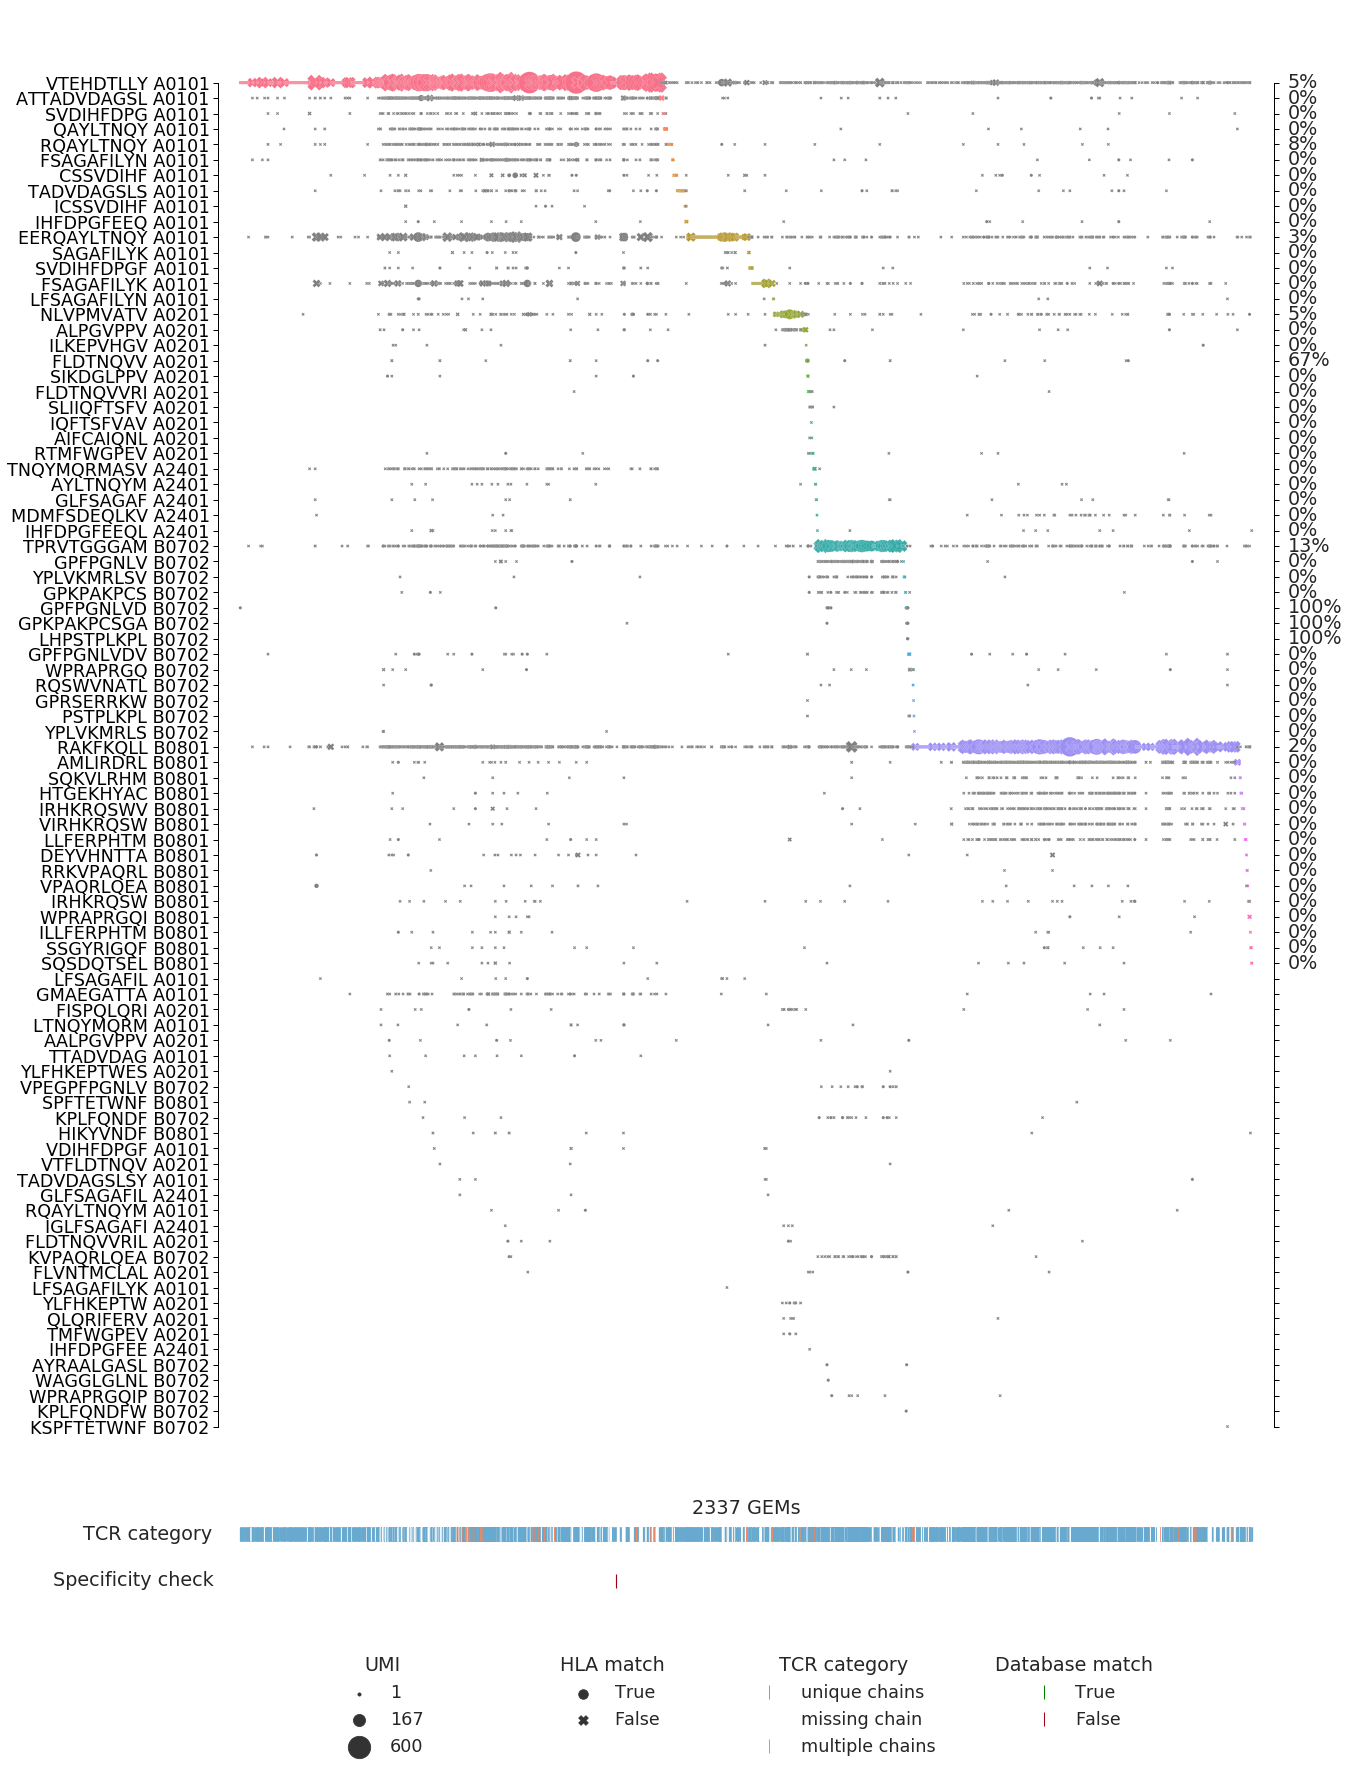

In [160]:
fig = plt.figure(figsize=(20,fig_height))
#fig.suptitle()

gs = gridspec.GridSpec(3, 1, height_ratios=[fig_height, 0.3, 0.3], hspace=0.3*6/fig_height) #6, left=0.05
ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1], sharex=ax1) #ax2 = plt.subplot(gs[0,1])
ax3 = fig.add_subplot(gs[2], sharex=ax1) #ax3 = plt.subplot(gs[0, 2])

#################################################
#                  Big scatter                  #
#################################################
#plt.figure(figsize=(20,6))

umi_max = plt_df.UMI.max() if plt_df.UMI.max() < 1000 else 1000
print(umi_max)
sns.scatterplot(data=plt_df[plt_df.pep_match], x='gem', y='peptide_HLA_lst',
                size='UMI', sizes=(10,500), size_norm=(1,umi_max),
                hue='umi_match', style='HLA match',
                legend='full', linewidth=lw, ax=ax1)
#ht,lt = ax1.get_legend_handles_labels()
sns.scatterplot(data=plt_df[plt_df.pep_match == False], x='gem', y='peptide_HLA_lst',
                size='UMI', sizes=(10,500), size_norm=(1,umi_max),
                color='grey', style='HLA match',
                legend=False, linewidth=lw, ax=ax1) # 
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_xlabel('%d GEMs' %plt_df.gem.nunique())
ax1.set_ylabel('')#Peptide HLA

if any(hla_df[hla_df.level_1].frac):
    for i,n in enumerate(hla_df[hla_df.level_1].frac):
        ax1.annotate(f'{int(round(n,0))}%', xy=(plt_df.gem.nunique() + 0.035*plt_df.gem.nunique(),i), annotation_clip=False, va='center')
    sns.despine(trim=True, bottom=True, right=False, offset={'left':-30, 'right':-30}, ax=ax1)
    ax1.tick_params(right=True)
else:
    sns.despine(trim=True, bottom=True, offset={'left':-30}, ax=ax1)

ht,lt = ax1.get_legend_handles_labels()
h1,l1 = clean_legend(ht,lt)
#ax1.legend(h1, l1, bbox_to_anchor=(1.0001, 0.5), loc=6, frameon=False, labelspacing=1)#, title='In VDJdb'

#################################################
#                 TCR category                  #
#################################################
sns.scatterplot(data=plt_df, x='gem', y='static', hue='TCR category', palette=['#67a9cf','white','#ef8a62'], s=200, marker='|', legend='full', ax=ax2)#'#ffffbf'
sns.despine(left=True, bottom=True, ax=ax2)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_ylabel('TCR category', rotation=0, va='center', labelpad=40)
ax2.set_xlabel('')
h2,l2 = ax2.get_legend_handles_labels()
h2 = [Line2D([], [], color=h.get_facecolor()[0], linestyle='', marker='|') for h in h2]
#ax2.legend(h2, l2, bbox_to_anchor=(1.0001, 0.5), loc=6, ncol=3, frameon=False) #, title='Chain annotation'
#################################################
#                Database match                 #
#################################################
sns.scatterplot(data=plt_df, x='gem', y='static', color='white', marker='|', legend=False, ax=ax3)
sns.scatterplot(data=plt_df, x='gem', y='static', hue='Database match', palette=['green','#9d0216'], s=200, marker='|', legend='full', ax=ax3)
sns.despine(left=True, bottom=True, ax=ax3)
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_ylabel('Specificity check', rotation=0, va='center', labelpad=55)
ax3.set_xlabel('')
h3,l3 = ax3.get_legend_handles_labels()
h3 = [Line2D([], [], color=h.get_facecolor()[0], linestyle='', marker='|') for h in h3]
#ax3.legend(h3[1:], l3[1:], bbox_to_anchor=(1.0001, 0.5), loc=6, ncol=2, frameon=False)#, title='In VDJdb'

#ax1.legend(h1+h2+h3, l1+l2+l3, bbox_to_anchor=(1.0001, 0.5), loc=6, frameon=False, labelspacing=1)#, title='In VDJdb'

fig.legend(h1[1:-3],l1[1:-3],bbox_to_anchor=(0.26, 0.1), loc=9, frameon=False, labelspacing=0.5, bbox_transform=fig.transFigure, title='UMI')
ax1.legend(h1[-2:], l1[-2:], bbox_to_anchor=(0.42, 0.1), loc=9, frameon=False, labelspacing=0.5, bbox_transform=fig.transFigure, title='HLA match', markerscale=2)
ax2.legend(h2[0:], l2[0:], bbox_to_anchor=(0.58, 0.1), loc=9, frameon=False, labelspacing=0.5, bbox_transform=fig.transFigure, markerscale=3, title='TCR category')
ax3.legend(h3[0:], l3[0:], bbox_to_anchor=(0.74, 0.1), loc=9, frameon=False, labelspacing=0.5, bbox_transform=fig.transFigure, markerscale=3, title='Database match')

plt.savefig(PNG, bbox_inches='tight', dpi=300)
plt.savefig(PDF, bbox_inches='tight')
plt.show()

In [134]:
lt

['UMI',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '21',
 '22',
 '23',
 '24',
 '25',
 '27',
 '28',
 '31',
 '32',
 '34',
 '35',
 '36',
 '37',
 '39',
 '40',
 '41',
 '44',
 '47',
 '48',
 '49',
 '51',
 '52',
 '53',
 '54',
 '56',
 '58',
 '59',
 '60',
 '61',
 '63',
 '65',
 '66',
 '67',
 '69',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '80',
 '82',
 '83',
 '84',
 '85',
 '86',
 '88',
 '92',
 '94',
 '95',
 '96',
 '102',
 '105',
 '106',
 '107',
 '108',
 '109',
 '112',
 '115',
 '122',
 '125',
 '126',
 '130',
 '165',
 '168',
 'HLA match',
 'True',
 'False']

In [34]:
import matplotlib
matplotlib.rcParams['font.family']

['sans-serif']

In [74]:
df

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,ct_sample,ct_pep,ct_hla,sample_hla,pep_match,hla_match,ct_match,valid_ct,train_label,test_label
0,AAACCTGAGCCCAGCT-1,clonotype4860,4860.0,4860.0,TRAV8-3;TRAJ10;TRAC,TRBV6-5;;TRBJ1-2;TRBC1,['TRAV8-3;TRAJ10;TRAC'],['TRBV2;;TRBJ1-3;TRBC1' 'TRBV6-5;;TRBJ1-2;TRBC1'],684.0,YGATPY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
1,AAACCTGAGTCAATAG-1,clonotype2833,2833.0,2833.0,TRAV17;TRAJ38;TRAC,TRBV19;;TRBJ2-7;TRBC2,['TRAV17;TRAJ38;TRAC'],['TRBV19;;TRBJ2-7;TRBC2'],518.0,TSINN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
2,AAACCTGCAATCCGAT-1,clonotype4,4.0,4.0,TRAV1-1;TRAJ10;TRAC,TRBV5-1;;TRBJ2-5;TRBC2,['TRAV1-1;TRAJ10;TRAC'],['TRBV5-1;;TRBJ2-5;TRBC2'],496.0,TSGFYG,...,8.0,RPHERNGFTVL B0702,B0702,['B0702'],True,True,True,True,True,True
3,AAACCTGCAGCCAGAA-1,clonotype115,115.0,115.0,TRAV21;TRAJ33;TRAC,TRBV10-2;;TRBJ1-1;TRBC1,['TRAV21;TRAJ33;TRAC'],['TRBV10-2;;TRBJ1-1;TRBC1'],472.0,DSAIYN,...,1.0,CLGGLLTMV A0201,NaN,['A0201'],True,True,True,True,True,True
4,AAACCTGCATGCCACG-1,clonotype25,25.0,25.0,TRAV17;TRAJ12;TRAC,TRBV7-9;;TRBJ2-1;TRBC2,['TRAV17;TRAJ12;TRAC'],['TRBV7-9;;TRBJ2-1;TRBC2'],589.0,TSINN,...,7.0,TPRVTGGGAM B0702,B0702,['B0702'],True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,TTTGGTTGTTGAGGTG-1,clonotype2,2.0,2.0,NaN,TRBV28;;TRBJ2-7;TRBC2,NaN,['TRBV28;;TRBJ2-7;TRBC2'],NaN,NaN,...,10.0,RVRAYTYSK A0301,NaN,"['A0201', 'A0301']",True,True,True,True,True,True
7107,TTTGTCAAGAATGTTG-1,NaN,0.0,544.0,NaN,TRBV6-1;;TRBJ2-7;TRBC2,NaN,['TRBV6-1;;TRBJ2-7;TRBC2'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
7108,TTTGTCAAGCGTGAAC-1,NaN,0.0,2011.0,NaN,TRBV20-1;;TRBJ2-1;TRBC2,NaN,['TRBV20-1;;TRBJ2-1;TRBC2'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
7109,TTTGTCATCACCTCGT-1,clonotype2176,2176.0,2176.0,NaN,TRBV19;TRBD1;TRBJ1-5;TRBC1,NaN,['TRBV19;TRBD1;TRBJ1-5;TRBC1'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False


In [27]:
df = calc_binding_concordance(df.copy(), 'ct')

In [40]:
# Define order for peptides
rank = {'GILGFVFTL A0201':1,'GLCTLVAML A0201':2,'NLVPMVATV A0201':3,'CLGGLLTMV A0201':4,
        'FLYALALLL A0201':5,'VLEETSVML A0201':6,'YVLDHLIVV A0201':7,
        'RVRAYTYSK A0301':8,'RPHERNGFTV B0702':9,'RPHERNGFTVL B0702':10,
        'RPPIFIRRL B0702':11,'TPRVTGGGAM B0702':12,'TPSVSSSISSL B0702':13}
df['rank'] = df.peptide_HLA.map(rank)

# Sort
df.ct = df.ct.astype(int).astype(str)
df.sort_values(by=['rank','gems_per_specificity','binding_concordance'], #,'ct'
                   ascending=[True, False, False], inplace=True) #, True

# devide GEMs by max concordance and outliers
dct = df.groupby('ct').binding_concordance.max()
df['max_conc'] = df.ct.map(dct)
idx = df.binding_concordance == df.max_conc

def modify_legend(h,l):
    flag = False
    labels = []
    handles = []
    for e, le in enumerate(l):
        if flag:
            if (int(le) % 10 == 0) | (le == '1'):
                labels.append(le)
                handles.append(h[e])
        if le == 'gems_per_specificity':
            flag = True
    return handles, labels

fig = plt.figure(figsize=(20,6))
sns.scatterplot(data=df[idx], x='ct', y='peptide_HLA',
                size='gems_per_specificity', sizes=(10,1000), size_norm=(1,df.gems_per_specificity.max()),
                hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                legend='full', linewidth=0)
sns.scatterplot(data=df[~idx], x='ct', y='peptide_HLA',
                size='gems_per_specificity', sizes=(10,1000), size_norm=(1,df.gems_per_specificity.max()),
                hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                legend=False, linewidth=0)
ax = plt.gca()
sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap='viridis_r') # hack for cbar
sm.set_array([]) # hack for cbar
#fig.colorbar(sm, ax=ax, pad=0.01)
fig.colorbar(sm, ax=ax, orientation='horizontal', label='Binding Concordance', fraction=0.06) #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html
        
h,l = ax.get_legend_handles_labels()
h,l = modify_legend(h,l)
ax.legend(h, l, bbox_to_anchor=(0.5, -0.5), loc=9, frameon=False, title='GEMs', ncol=len(l))

#plt.title('%d clonotypes (%d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
plt.xlabel('%d clonotypes (across %d GEMs)' %(df.ct.nunique(), df.gem.nunique()))
#plt.xlabel('')
plt.ylabel('')

sns.despine(bottom=False, trim=True, offset={'left':-30})
ax.set_xticks([])
ax.set_xticklabels([])
plt.show()

In [126]:
labels

['1', '10', '20', '40', '70', '310']

In [127]:
handles

In [102]:
df[idx & (df.peptide_HLA == 'RVRAYTYSK A0301')].ct.unique()

array(['2', '12', '22', ..., '277', '86', '56'], dtype=object)

In [97]:
df.peptide_HLA.unique()

array(['GILGFVFTL A0201', 'GLCTLVAML A0201', 'NLVPMVATV A0201',
       'CLGGLLTMV A0201', 'FLYALALLL A0201', 'VLEETSVML A0201',
       'YVLDHLIVV A0201', 'RVRAYTYSK A0301', 'RPHERNGFTV B0702',
       'RPHERNGFTVL B0702', 'RPPIFIRRL B0702', 'TPRVTGGGAM B0702',
       'TPSVSSSISSL B0702'], dtype=object)

In [31]:
df.loc[:,['peptide_HLA','HLA_cd8','HLA_match']]

,peptide_HLA,HLA_cd8,HLA_match
0,RPHERNGFTVL B0702,"[A0201, B0702]",True
1,RVRAYTYSK A0301,"[A0201, A0301]",True
2,RPHERNGFTVL B0702,[B0702],True
3,CLGGLLTMV A0201,[A0201],True
4,TPRVTGGGAM B0702,[B0702],True
...,...,...,...
7106,RVRAYTYSK A0301,"[A0201, A0301]",True
7107,TPRVTGGGAM B0702,"[A0201, A0301]",False
7108,RVRAYTYSK A0301,[B0702],False
7109,RVRAYTYSK A0301,[A0201],False


In [15]:
vdjdb_gems = df.loc[~df.VDJdb_check.isna(),
                    ['VDJdb_check','gem','ct','cdr3_TRA','genes_TRA','cdr3_TRB','genes_TRB','peptide_HLA_lst','peptide_HLA',
                     'umi_count_lst_mhc','delta_umi_mhc']]#.gem
vdjdb_gems.sort_values(by=['ct','peptide_HLA'], inplace=True)

In [17]:
vdjdb_gems.to_csv('tmp_files/db_hits.csv', index=False)
vdjdb_gems.to_excel('tmp_files/df_hits.xlsx', index=False)

In [67]:
sum(df.groupby('ct').gem.size() > 10)

60

In [31]:
plt_df[plt_df.gem.isin(vdjdb_gems)]

,gem,ct,rank,peptide_HLA,peptide_HLA_lst,umi_count_mhc,UMI,HLA_cd8,umi_count_lst_TRA,umi_count_lst_TRB,chain_count_TRA,chain_count_TRB,VDJdb match,TCR category,tmp_cat,HLA match,pep_match,umi_match,static
2208,CTAGTGATCCATGCTC-1,883,2,GLCTLVAML A0201,GLCTLVAML A0201,23.0,23,"[A0201, B0702]",[5],[16],1,1,True,unique chains,NaN,True,True,GLCTLVAML A0201,1
2695,GACTACAGTCAGCTAT-1,3697,2,GLCTLVAML A0201,GLCTLVAML A0201,23.0,23,[A0201],[1],[19],1,1,True,unique chains,NaN,True,True,GLCTLVAML A0201,1
2208,CTAGTGATCCATGCTC-1,883,2,GLCTLVAML A0201,RVRAYTYSK A0301,23.0,9,"[A0201, B0702]",[5],[16],1,1,True,unique chains,NaN,False,False,grey,1
2695,GACTACAGTCAGCTAT-1,3697,2,GLCTLVAML A0201,RVRAYTYSK A0301,23.0,6,[A0201],[1],[19],1,1,True,unique chains,NaN,False,False,grey,1
2155,CTACCCAGTTCCGGCA-1,5316,3,NLVPMVATV A0201,NLVPMVATV A0201,26.0,26,"[A0201, A0301]",[5],[5],1,1,True,unique chains,NaN,True,True,NLVPMVATV A0201,1
3660,GTTCGGGTCGCACTCT-1,5317,3,NLVPMVATV A0201,NLVPMVATV A0201,24.0,24,[A0201],[1],[4],1,1,True,unique chains,NaN,True,True,NLVPMVATV A0201,1
2155,CTACCCAGTTCCGGCA-1,5316,3,NLVPMVATV A0201,RVRAYTYSK A0301,26.0,21,"[A0201, A0301]",[5],[5],1,1,True,unique chains,NaN,True,False,grey,1
2155,CTACCCAGTTCCGGCA-1,5316,3,NLVPMVATV A0201,CLGGLLTMV A0201,26.0,2,"[A0201, A0301]",[5],[5],1,1,True,unique chains,NaN,True,False,grey,1
1172,CACAGGCTCGAGAACG-1,162,5,FLYALALLL A0201,FLYALALLL A0201,38.0,38,"[A0201, A0301]",[2],[3],1,1,True,unique chains,NaN,True,True,FLYALALLL A0201,1
1958,CGGCTAGTCTGCAAGT-1,162,5,FLYALALLL A0201,FLYALALLL A0201,22.0,22,"[A0201, A0301]",[2],[8],1,1,True,unique chains,NaN,True,True,FLYALALLL A0201,1


In [ ]:
def get_legend_n_handle(l,h,key='gem'):
    leg = list()
    hdl = list()
    if key is None:
        keep = True
    else:
        keep = False
    for i,e in enumerate(l):
        if keep:
            if int(float(e)) > 0:
                leg.append(int(float(e)))
                hdl.append(h[i])
        if e == key:
            keep = True
    return hdl, leg

Text(0.5, 0, '')

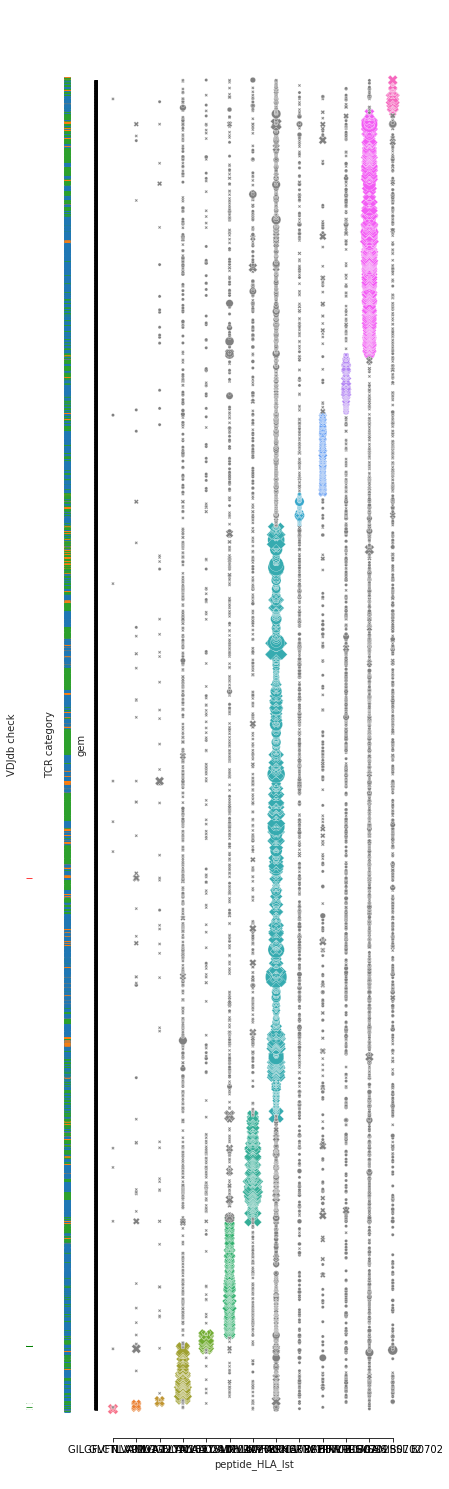

In [22]:
fig = plt.figure(figsize=(7,27))
#fig.suptitle()

gs = gridspec.GridSpec(1, 3, width_ratios=[0.3, 0.3, 6.3], hspace=0.1) #, left=0.05
ax3 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1]) #ax2 = plt.subplot(gs[0,1])
ax1 = fig.add_subplot(gs[2]) #ax3 = plt.subplot(gs[0, 2])

#################################################
#                  Big scatter                  #
#################################################
#plt.figure(figsize=(20,6))
sns.scatterplot(data=plt_df[plt_df.pep_match], y='gem', x='peptide_HLA_lst',
                size='umi_count_lst_mhc', sizes=(10,500), size_norm=(1,plt_df.umi_count_lst_mhc.max()),
                hue='umi_match', style='HLA_match',
                legend=False, linewidth=0.25, ax=ax1)
sns.scatterplot(data=plt_df[plt_df.pep_match == False], y='gem', x='peptide_HLA_lst',
                size='umi_count_lst_mhc', sizes=(10,500), size_norm=(1,plt_df.umi_count_lst_mhc.max()),
                color='grey', style='HLA_match',
                legend=False, linewidth=0.25, ax=ax1)
ax1.set_yticklabels([])
#ax1.set_xticklabels(rotation=90)
sns.despine(trim=True, offset={'bottom':-40}, ax=ax1)

#################################################
#                  TRA chains                   #
#################################################
sns.scatterplot(data=plt_df, y='gem', x='static', hue='tcr_category', marker='_', legend=False, ax=ax2)
sns.despine(left=True, bottom=True, ax=ax2)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_ylabel('TCR category')
ax2.set_xlabel('')
#################################################
#                  TRB chains                   #
#################################################
sns.scatterplot(data=plt_df, y='gem', x='static', hue='VDJdb_check', palette=['white','red','green'], marker='_', legend=False, ax=ax3)
sns.despine(left=True, bottom=True, ax=ax3)
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.set_yticks([])
ax3.set_yticklabels([])
ax3.set_ylabel('VDJdb check')
ax3.set_xlabel('')

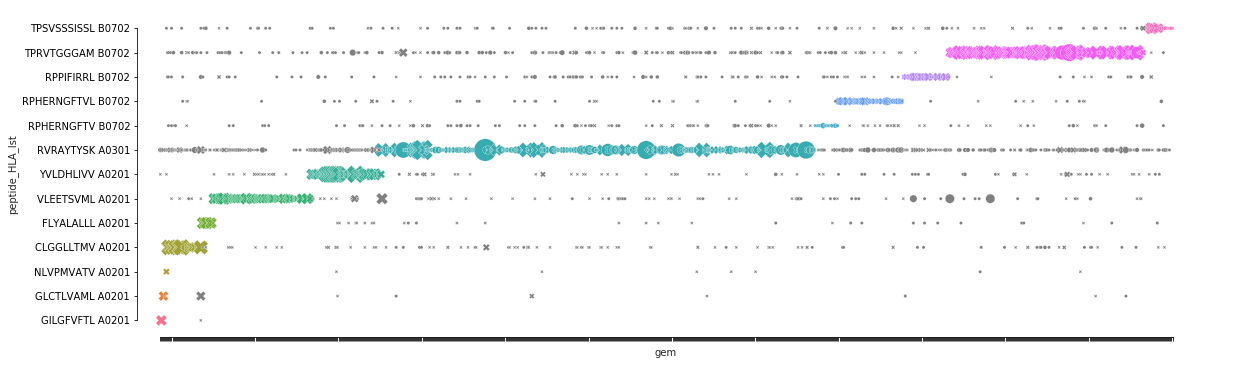

In [129]:
plt.figure(figsize=(20,6))
sns.scatterplot(data=plt_df[plt_df.pep_match], x='gem', y='peptide_HLA_lst',
                size='umi_count_lst_mhc', sizes=(10,500), size_norm=(1,plt_df.umi_count_lst_mhc.max()),
                hue='umi_match', style='HLA_match',
                legend=False, linewidth=0.25)
sns.scatterplot(data=plt_df[plt_df.pep_match == False], x='gem', y='peptide_HLA_lst',
                size='umi_count_lst_mhc', sizes=(10,500), size_norm=(1,plt_df.umi_count_lst_mhc.max()),
                color='grey', style='HLA_match',
                legend=False, linewidth=0.25)
ax = plt.gca()
ax.set_xticklabels([])
sns.despine(trim=True, offset={'left':-30})
plt.show()

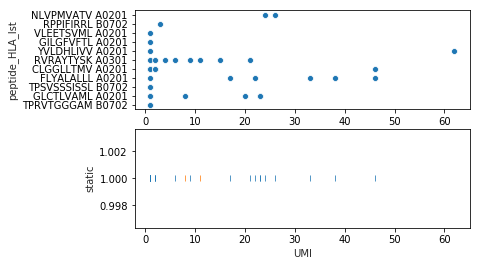

In [199]:
fig = plt.figure()
gs = gridspec.GridSpec(2,1)
ax1 = fig.add_subplot(gs[0])

sns.scatterplot(data=plt_df[plt_df.gem.isin(vdjdb_gems.to_list() + ['AGCCTAATCACAGGCC-1','AGAGTGGCAGCCTTGG-1'])].sort_values(by='UMI'), x='UMI', y='peptide_HLA_lst', legend=False, ax=ax1)

ax2 = fig.add_subplot(gs[1], sharex=ax1)
sns.scatterplot(data=plt_df[plt_df.gem.isin(vdjdb_gems.to_list() + ['AGCCTAATCACAGGCC-1','AGAGTGGCAGCCTTGG-1'])], x='UMI', y='static', hue='in VDJdb', marker='|', legend=False, ax=ax2)

#labels = ax1.get_xticklabels()
#ax1.set_xticklabels(labels, rotation=90)

In [190]:
vdjdb_gems

626     AGATCTGTCACTCTTA-1
1172    CACAGGCTCGAGAACG-1
1958    CGGCTAGTCTGCAAGT-1
2155    CTACCCAGTTCCGGCA-1
2183    CTAGCCTAGTCCAGGA-1
2208    CTAGTGATCCATGCTC-1
2695    GACTACAGTCAGCTAT-1
3435    GTATTCTAGTAGCCGA-1
3660    GTTCGGGTCGCACTCT-1
3909    TAGTTGGAGTATCGAA-1
Name: gem, dtype: object

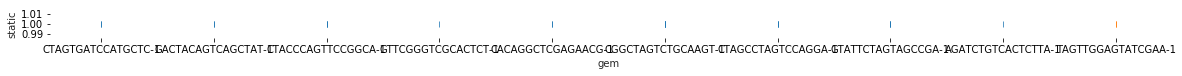

In [165]:
plt.figure(figsize=(20,0.5))
sns.scatterplot(data=plt_df, x='gem', y='static', hue='in VDJdb', marker='|', legend=False)
sns.despine(left=True, bottom=True)
ax = plt.gca()
#ax.set_xticks([])
#ax.set_xticklabels([])
#ax.set_yticks([])
#ax.set_yticklabels([])
#ax.set_ylabel('TRA', rotation=0, va='center', labelpad=-10)
#ax.set_xlabel('')
plt.show()

In [179]:
plt_df[plt_df.gem.isin(vdjdb_gems.to_list() + ['AGCCTAATCACAGGCC-1','AGAGTGGCAGCCTTGG-1'])]

,gem,ct,rank,peptide_HLA,peptide_HLA_lst,umi_count_mhc,UMI,HLA_cd8,umi_count_lst_TRA,umi_count_lst_TRB,chain_count_TRA,chain_count_TRB,in VDJdb,TCR category,HLA match,pep_match,umi_match,static,tmp_cat
2208,CTAGTGATCCATGCTC-1,883,2,GLCTLVAML A0201,GLCTLVAML A0201,23.0,23,"[A0201, B0702]",[5],[16],1,1,True,unique chains,True,True,GLCTLVAML A0201,1,NaN
2695,GACTACAGTCAGCTAT-1,3697,2,GLCTLVAML A0201,GLCTLVAML A0201,23.0,23,[A0201],[1],[19],1,1,True,unique chains,True,True,GLCTLVAML A0201,1,NaN
2208,CTAGTGATCCATGCTC-1,883,2,GLCTLVAML A0201,RVRAYTYSK A0301,23.0,9,"[A0201, B0702]",[5],[16],1,1,True,unique chains,False,False,grey,1,NaN
2695,GACTACAGTCAGCTAT-1,3697,2,GLCTLVAML A0201,RVRAYTYSK A0301,23.0,6,[A0201],[1],[19],1,1,True,unique chains,False,False,grey,1,NaN
2155,CTACCCAGTTCCGGCA-1,5316,3,NLVPMVATV A0201,NLVPMVATV A0201,26.0,26,"[A0201, A0301]",[5],[5],1,1,True,unique chains,True,True,NLVPMVATV A0201,1,NaN
3660,GTTCGGGTCGCACTCT-1,5317,3,NLVPMVATV A0201,NLVPMVATV A0201,24.0,24,[A0201],[1],[4],1,1,True,unique chains,True,True,NLVPMVATV A0201,1,NaN
2155,CTACCCAGTTCCGGCA-1,5316,3,NLVPMVATV A0201,RVRAYTYSK A0301,26.0,21,"[A0201, A0301]",[5],[5],1,1,True,unique chains,True,False,grey,1,NaN
2155,CTACCCAGTTCCGGCA-1,5316,3,NLVPMVATV A0201,CLGGLLTMV A0201,26.0,2,"[A0201, A0301]",[5],[5],1,1,True,unique chains,True,False,grey,1,NaN
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,CLGGLLTMV A0201,46.0,46,"[A0201, A0301]","[2, 4]","[6, 11]",2,2,NaN,multiple chains,True,True,CLGGLLTMV A0201,1,multiple chains
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,RPPIFIRRL B0702,46.0,3,"[A0201, A0301]","[2, 4]","[6, 11]",2,2,NaN,multiple chains,False,False,grey,1,multiple chains


In [106]:
plt_df[(plt_df.pep_match == False) & (plt_df.peptide_HLA_lst == 'GLCTLVAML A0201')]

,gem,ct,rank,peptide_HLA,peptide_HLA_lst,umi_count_mhc,umi_count_lst_mhc,HLA_cd8,umi_count_lst_TRA,umi_count_lst_TRB,chain_count_TRA,chain_count_TRB,VDJdb_check,HLA_match,umi_match,pep_match
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,GLCTLVAML A0201,46.0,20,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,True,grey,False
606,AGAGTGGCAGCCTTGG-1,32,7,YVLDHLIVV A0201,GLCTLVAML A0201,62.0,1,"[A0201, A0301]",[4],[7],1.0,1.0,NaN,True,grey,False
469,ACGTCAATCACCCTCA-1,9,8,RVRAYTYSK A0301,GLCTLVAML A0201,19.0,1,"[A0301, B0702]",[5],[17],1.0,1.0,NaN,False,grey,False
490,ACTATCTTCCAGATCA-1,352,8,RVRAYTYSK A0301,GLCTLVAML A0201,16.0,5,"[A0201, A0301]",[2],[7],1.0,1.0,NaN,True,grey,False
881,ATCATCTCACAGTCGC-1,4018,8,RVRAYTYSK A0301,GLCTLVAML A0201,8.0,1,"[A0201, A0301]",[2],[4],1.0,1.0,NaN,True,grey,False
363,ACCTTTAGTTACGGAG-1,10,11,RPPIFIRRL B0702,GLCTLVAML A0201,3.0,1,"[A0301, B0702]",[2],[5],1.0,1.0,NaN,False,grey,False
102,AACGTTGGTTAGTGGG-1,1841,12,TPRVTGGGAM B0702,GLCTLVAML A0201,2.0,1,"[A0201, A0301]",[2],[7],1.0,1.0,NaN,True,grey,False
853,ATAAGAGAGACGACGT-1,5678,12,TPRVTGGGAM B0702,GLCTLVAML A0201,17.0,1,[B0702],[2],[],1.0,0.0,NaN,False,grey,False


In [107]:
plt_df[plt_df.gem=='AGCCTAATCACAGGCC-1']

,gem,ct,rank,peptide_HLA,peptide_HLA_lst,umi_count_mhc,umi_count_lst_mhc,HLA_cd8,umi_count_lst_TRA,umi_count_lst_TRB,chain_count_TRA,chain_count_TRB,VDJdb_check,HLA_match,umi_match,pep_match
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,CLGGLLTMV A0201,46.0,46,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,True,CLGGLLTMV A0201,True
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,GLCTLVAML A0201,46.0,20,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,True,grey,False
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,RVRAYTYSK A0301,46.0,15,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,True,grey,False
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,VLEETSVML A0201,46.0,1,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,True,grey,False
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,GILGFVFTL A0201,46.0,1,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,True,grey,False
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,RPPIFIRRL B0702,46.0,3,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,False,grey,False
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,TPSVSSSISSL B0702,46.0,1,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,False,grey,False
658,AGCCTAATCACAGGCC-1,7025,4,CLGGLLTMV A0201,TPRVTGGGAM B0702,46.0,1,"[A0201, A0301]","[2, 4]","[6, 11]",2.0,2.0,NaN,False,grey,False
